**Importing Libraries and Reading Input data files**

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics

In [2]:
train = pd.read_csv('../input/fake-news/train.csv')
test = pd.read_csv('../input/fake-news/test.csv')

**Function for pre-processing input data to remove non-alphabet characters, perform PorterStemmer() & remove stop-words**

In [3]:
from tqdm import tqdm
def pre_process(X):
    corpus = []
    X = np.array(X)
    ps = PorterStemmer()
    for i in tqdm(X):
        #print(i)
        txt = re.sub('[^a-zA-Z]', ' ', i)
        txt = txt.lower()
        txt = txt.split()
        #print(len(txt))
        txt = [ps.stem(word) for word in txt if not word in stopwords.words('english')]
        txt = ' '.join(txt)

        corpus.append(txt)
        
    return corpus
    

**Cleaning-up data using the pre_process() function**

In [4]:
train['text'] = train['text'].fillna(train['title'])

In [5]:
train = train.drop(['id','title','author'],axis = 1)

In [6]:
test['text'] = test['text'].fillna(test['title'])

In [7]:
test = test.drop(['id','title','author'],axis = 1)

In [8]:
train['text'] = train['text'].astype(str)
test['text'] = test['text'].astype(str)

In [9]:
train['text'] = pre_process(train['text'])

100%|██████████| 20800/20800 [50:41<00:00,  6.84it/s]


In [10]:
test['text'] = pre_process(test['text'])

100%|██████████| 5200/5200 [12:58<00:00,  6.68it/s]


In [11]:
X = train['text'].values
y = train['label'].values

**Transform text data via TfidfVectorizer()**

In [12]:
tfidf_v=TfidfVectorizer(max_features=10000,ngram_range=(1,3))
X_tfidf=tfidf_v.fit_transform(X).toarray()

In [13]:
X_train, X_dev, y_train, y_dev = train_test_split(X_tfidf, y, test_size=0.2, random_state=1)

**Model training & results using PassiveAggressiveClassifier**

accuracy:   0.961


<AxesSubplot:>

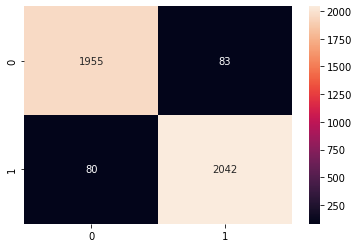

In [14]:
from sklearn.linear_model import PassiveAggressiveClassifier
clf_PA = PassiveAggressiveClassifier(random_state=1)

clf_PA.fit(X_train, y_train)
pred = clf_PA.predict(X_dev)
score = metrics.accuracy_score(y_dev, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_dev, pred)
sns.heatmap(cm,annot=True,fmt='g')

**Model training & results using LogisticRegression**

accuracy:   0.950


<AxesSubplot:>

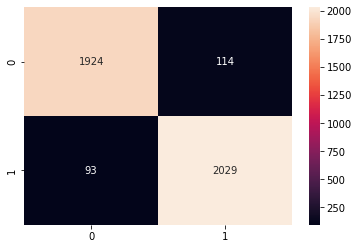

In [15]:
from sklearn.linear_model import LogisticRegression
clf_LR=LogisticRegression(random_state=1)

clf_LR.fit(X_train, y_train)
pred = clf_LR.predict(X_dev)
score = metrics.accuracy_score(y_dev, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_dev, pred)
sns.heatmap(cm,annot=True,fmt='g')

**Predicting values using clf_PA model - final submission received a score of ~0.55**

In [16]:
X_test = test['text'].values
X_test_tfidf=tfidf_v.fit_transform(X_test).toarray()

In [17]:
pred_PA = clf_PA.predict(X_test_tfidf)

In [18]:
test_2 = pd.read_csv('../input/fake-news/test.csv')
test_2['text'] = test_2['text'].fillna(test_2['title'])
test_2['text'] = test_2['text'].astype(str)
test_2['text'] = pre_process(test_2['text'])
X_test_2 = test_2['text'].values
X_test_tfidf_2=tfidf_v.fit_transform(X_test_2).toarray()

100%|██████████| 5200/5200 [13:17<00:00,  6.52it/s]


In [19]:
pred_PA_2 = clf_PA.predict(X_test_tfidf_2)

In [20]:
output_PA = pd.DataFrame({'id': test_2['id'], 'label': pred_PA_2.astype(int)})

In [21]:
output_PA.to_csv('./submission4.csv', index = False)

**Now using Word Embeddings + basic (1 Layer) Bi-Directional LSTM model **

In [22]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

voc_size=10000

onehot_repr=[one_hot(words,voc_size)for words in X] 

**Tried different values for sentence length (one example mentioned below)**

In [23]:
sent = {}
for i in onehot_repr:
    if len(i) in sent:
        sent[len(i)]+=1
    else:
        sent[len(i)]=1
        


In [24]:
k = sent.keys()
v = sent.values()

In [25]:
cntr = 0
tot = 0
for k,v in sent.items():
    if k <=300:
        cntr+=v
    tot+=v

cntr/tot

0.48875

In [26]:
sent_length=300
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)

In [27]:
from tensorflow.keras.layers import Bidirectional

from tensorflow.keras.layers import Dropout

embedding_vector_features=50
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

2022-06-02 23:07:39.675214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 23:07:39.829396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 23:07:39.830497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 23:07:39.832614: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 50)           500000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               120800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 621,001
Trainable params: 621,001
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [29]:
X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(X_final, y_final, test_size=0.3, random_state=42)

In [30]:
model1.fit(X_train_LSTM,y_train_LSTM,validation_data=(X_test_LSTM,y_test_LSTM),epochs=10,batch_size=64)

2022-06-02 23:07:52.722297: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-06-02 23:07:56.989358: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


228/228 [==============================] - 16s 45ms/step - loss: 0.3526 - accuracy: 0.8468 - val_loss: 0.1954 - val_accuracy: 0.9261
Epoch 2/10
228/228 [==============================] - 10s 42ms/step - loss: 0.1366 - accuracy: 0.9533 - val_loss: 0.1950 - val_accuracy: 0.9272
Epoch 3/10
228/228 [==============================] - 10s 46ms/step - loss: 0.0913 - accuracy: 0.9703 - val_loss: 0.1918 - val_accuracy: 0.9370
Epoch 4/10
228/228 [==============================] - 10s 43ms/step - loss: 0.0801 - accuracy: 0.9709 - val_loss: 0.2438 - val_accuracy: 0.9237
Epoch 5/10
228/228 [==============================] - 10s 43ms/step - loss: 0.0597 - accuracy: 0.9793 - val_loss: 0.2577 - val_accuracy: 0.9196
Epoch 6/10
228/228 [==============================] - 11s 47ms/step - loss: 0.0467 - accuracy: 0.9841 - val_loss: 0.2649 - val_accuracy: 0.9327
Epoch 7/10
228/228 [==============================] - 10s 43ms/step - loss: 0.0304 - accuracy: 0.9911 - val_loss: 0.4032 - val_accuracy: 0.9107
Epo

**Predicting values using model1 (Word Embeddings + Bi-Directional LSTM) - final submission received a score of ~0.92**

In [31]:
y_pred_LSTM=model1.predict(X_test_LSTM)

In [32]:
thresh = 0.5
final_pred = []
for i in y_pred_LSTM:
    if i >= thresh:
        final_pred.append(1)
    else:
        final_pred.append(0)

<AxesSubplot:>

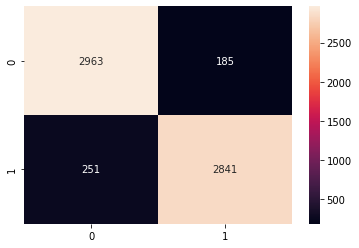

In [33]:
cm = metrics.confusion_matrix(y_test_LSTM, final_pred)
sns.heatmap(cm,annot=True,fmt='g')

In [34]:
score = metrics.accuracy_score(y_test_LSTM, final_pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.930


In [35]:
onehot_repr_test=[one_hot(words,voc_size)for words in X_test]
embedded_docs_test=pad_sequences(onehot_repr_test,padding='pre',maxlen=sent_length)
X_test_final=np.array(embedded_docs_test)
test_pred_LSTM=model1.predict(X_test_final)


In [36]:
thresh = 0.5
final_test_pred = []
for i in test_pred_LSTM:
    if i >= thresh:
        final_test_pred.append(1)
    else:
        final_test_pred.append(0)

In [37]:

output_BDLSTM = pd.DataFrame({'id': test_2['id'], 'label': final_test_pred})
output_BDLSTM.to_csv('./submission_5.csv', index = False)